In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Create a Spark session
spark = SparkSession.builder.getOrCreate()
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)
sc = spark.sparkContext
sc.setLogLevel("ERROR")

# Load data
train_data = spark.read.parquet("train_df.parquet")
test_data = spark.read.parquet("test_df.parquet")

# Filter out columns
columns_to_exclude = ['features', 'scaled_features']
train_data_filtered = train_data.drop(*columns_to_exclude)
test_data_filtered = test_data.drop(*columns_to_exclude)

# Selected features
selected_features = [
    'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment',
    'grade', 'sub_grade', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs',
    'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
    'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
    'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
    'last_pymnt_amnt', 'collections_12_mths_ex_med', 'annual_inc_joint', 'dti_joint',
    'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
    'addr_state_vec', 'purpose_vec', 'home_ownership_vec', 'next_pymnt_d_vec',
    'verification_status_joint_vec', 'verification_status_vec', 'pymnt_plan_vec',
    'initial_list_status_vec', 'application_type_vec'
]
class_counts = train_data_filtered.groupBy('default_ind').count().collect()
majority_class_count = class_counts[0]['count']
print(majority_class_count)
minority_class_count = class_counts[1]['count']
print(minority_class_count)
imbalance_ratio = majority_class_count / minority_class_count
print(imbalance_ratio)
# Undersample the majority class to match the minority class
undersampled_data = train_data_filtered.sampleBy(
    'default_ind', fractions={0: minority_class_count / majority_class_count, 1: 1.0}
)# Oversample the minority class to match the majority class
oversampled_data = train_data_filtered.unionAll(
    train_data_filtered.filter(col('default_ind') == 1)
    .sample(True, imbalance_ratio - 1)
)
assembler = VectorAssembler(inputCols=selected_features, outputCol="features")

# Assemble features
train_data = assembler.transform(train_data_filtered)
test_data = assembler.transform(test_data_filtered)
undersample = assembler.transform(undersampled_data)
oversample = assembler.transform(oversampled_data)


/opt/homebrew/Cellar/python@3.9/3.9.18/Frameworks/Python.framework/Versions/3.9/lib/python3.9/subprocess.py:1770: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/25 22:59:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


566896
32681
17.346348030966006


In [2]:
# Train Decision Tree Classifier
dt = DecisionTreeClassifier(featuresCol="features", labelCol="default_ind")
model = dt.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

# Evaluate the model
binary_evaluator = BinaryClassificationEvaluator(labelCol="default_ind", rawPredictionCol="rawPrediction")
roc_auc = binary_evaluator.evaluate(predictions, {binary_evaluator.metricName: "areaUnderROC"})
print(f"Area Under ROC Curve = {roc_auc:.2f}")

# Additional metrics
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="default_ind", predictionCol="prediction", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(predictions)
print(f"Test Accuracy = {accuracy:.2f}")

precision_evaluator = MulticlassClassificationEvaluator(labelCol="default_ind", predictionCol="prediction", metricName="precisionByLabel")
precision = precision_evaluator.evaluate(predictions)
print(f"Precision = {precision:.2f}")

recall_evaluator = MulticlassClassificationEvaluator(labelCol="default_ind", predictionCol="prediction", metricName="recallByLabel")
recall = recall_evaluator.evaluate(predictions)
print(f"Recall = {recall:.2f}")

f1_evaluator = MulticlassClassificationEvaluator(labelCol="default_ind", predictionCol="prediction", metricName="f1")
f1_score = f1_evaluator.evaluate(predictions)
print(f"F1 Score = {f1_score:.2f}")

Area Under ROC Curve = 0.94


Test Accuracy = 0.99


Precision = 0.99


Recall = 1.00


F1 Score = 0.99


In [3]:
# Convert PySpark DataFrames to Pandas DataFrames for TensorFlow usage
train_feature_pd = train_data.select('features').toPandas()
train_target_pd = train_data.select('default_ind').toPandas()
test_feature_pd = test_data.select('features').toPandas()
test_target_pd = test_data.select('default_ind').toPandas()

# Convert SparseVector to dense NumPy array
def sparse_vector_to_dense(sparse_vector):
    return sparse_vector.toArray()

# Convert feature and target DataFrames to NumPy arrays
train_features_array = np.array([sparse_vector_to_dense(row[0]) for row in train_feature_pd.values])
train_target_array = np.array(train_target_pd.values).flatten()

test_features_array = np.array([sparse_vector_to_dense(row[0]) for row in test_feature_pd.values])
test_target_array = np.array(test_target_pd.values).flatten()

# Convert NumPy arrays to TensorFlow tensors
train_features_tensor = tf.constant(train_features_array)
train_target_tensor = tf.constant(train_target_array)

test_features_tensor = tf.constant(test_features_array)
test_target_tensor = tf.constant(test_target_array)

# Create TensorFlow datasets from the tensors
train_dataset = tf.data.Dataset.from_tensor_slices((train_features_tensor, train_target_tensor))
test_dataset = tf.data.Dataset.from_tensor_slices((test_features_tensor, test_target_tensor))

batch_size = 512
train_ds = train_dataset.batch(batch_size)
test_ds = test_dataset.batch(batch_size)

Use /var/folders/kx/qpgsccg15pb6v1ttsc58ymm80000gn/T/tmpq26wftdp as temporary training directory
Reading training dataset...
Training dataset read in 0:00:04.026974. Found 599577 examples.
Training model...


[INFO 24-05-25 23:00:39.3418 AEST kernel.cc:1233] Loading model from path /var/folders/kx/qpgsccg15pb6v1ttsc58ymm80000gn/T/tmpq26wftdp/model/ with prefix dea2515828464ae8


Model trained in 0:00:27.861240
Compiling model...


[INFO 24-05-25 23:00:39.6070 AEST decision_forest.cc:734] Model loaded with 100 root(s), 205374 node(s), and 106 input feature(s).
[INFO 24-05-25 23:00:39.6070 AEST abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-05-25 23:00:39.6070 AEST kernel.cc:1061] Use fast generic engine


Model compiled.
501/501 [==============================] - 4s 4ms/step - loss: 0.0000e+00
Evaluation results (loss): {'loss': 0.0}
501/501 [==============================] - 2s 4ms/step


/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.95
F1 Score: 0.00
Precision: 0.00
Recall: 0.00
ROC AUC: 0.99
Confusion Matrix:
[[242606      0]
 [ 13786      0]]


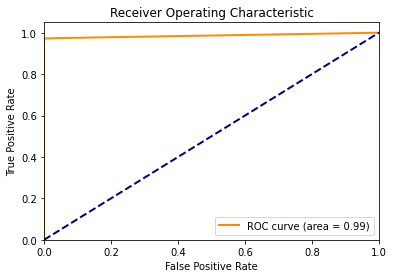

In [4]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score

# Train the model
rf_tf = tfdf.keras.RandomForestModel(num_trees=100)
rf_tf.fit(train_ds)

# Evaluate the model to get accuracy
rf_tf_evaluation = rf_tf.evaluate(test_ds, return_dict=True)

# Print the evaluation results (this only contains the loss)
print(f"Evaluation results (loss): {rf_tf_evaluation}")

# Get model predictions for the test set
predictions = rf_tf.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)

# Extract true labels from the test dataset
#true_labels = np.concatenate([y for x, y in test_ds], axis=0)
true_labels = test_target_tensor


# Print accuracy, F1 score, precision, recall, and ROC AUC
accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
roc_auc = roc_auc_score(true_labels, predictions)

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

# Print confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(f"Confusion Matrix:\n{conf_matrix}")

# Calculate and plot ROC curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(true_labels, predictions)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [17]:

# Training and evaluating TensorFlow Decision Forest model
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
import tensorflow_decision_forests as tfdf
from tensorflow.keras import layers
from tensorflow import keras
# Define the neural network architecture
model = tf.keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=(train_features_array.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Use binary crossentropy for binary classification
              metrics=['accuracy'])
check_point = "Feedfowrad.keras"
# Train the model
history = model.fit(train_ds, epochs=10, batch_size = 128, validation_data=test_ds,
                   callbacks=[
                       tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10),
                       keras.callbacks.ModelCheckpoint(check_point, save_best_only=True)
                   ])
model = keras.models.load_model(check_point)
# Evaluate the model
loss, accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {accuracy:.2f}")

# Get model predictions for the test set
predictions = model.predict(test_ds)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Extract true labels from the test dataset
true_labels = np.concatenate([y.numpy() for x, y in test_ds], axis=0)

# Calculate and print accuracy and F1 score
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

f1 = f1_score(true_labels, predicted_labels)
print(f"F1 Score: {f1:.2f}")

# Print confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(f"Confusion Matrix:\n{conf_matrix}")

# Calculate ROC AUC
auc = tf.keras.metrics.AUC(curve='ROC')
auc.update_state(true_labels, predictions)
roc_auc = auc.result().numpy()

print(f"ROC AUC: {roc_auc:.2f}")


Epoch 1/10


/opt/homebrew/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1172/1172 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9591 - loss: 545.8245 - val_accuracy: 0.0538 - val_loss: 79167.1172
Epoch 2/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9024 - loss: 2900.7314 - val_accuracy: 0.0619 - val_loss: 4936.9263
Epoch 3/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9048 - loss: 206.3578 - val_accuracy: 0.4973 - val_loss: 20.1937
Epoch 4/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9806 - loss: 1.2350 - val_accuracy: 0.5375 - val_loss: 12.5709
Epoch 5/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9863 - loss: 0.5577 - val_accuracy: 0.5896 - val_loss: 6.4576
Epoch 6/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9912 - loss: 0.3115 - val_accuracy: 0.6097 - val_loss: 3.2863
Epoch 7/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9948 - loss: 0.1304 - val_accuracy: 0.5457 - val_loss: 4.8277
Epoch 8/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9958 - loss: 0.09

2024-05-26 23:00:25.882410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


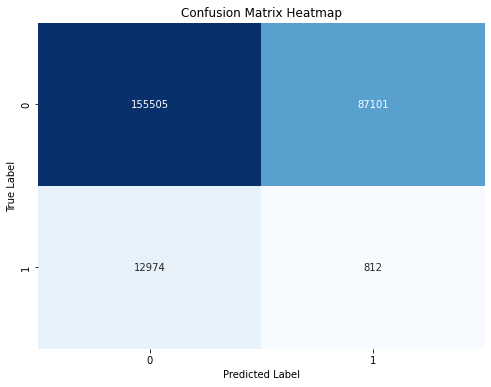

In [18]:
import seaborn as sns

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

(0.0, 1.0)

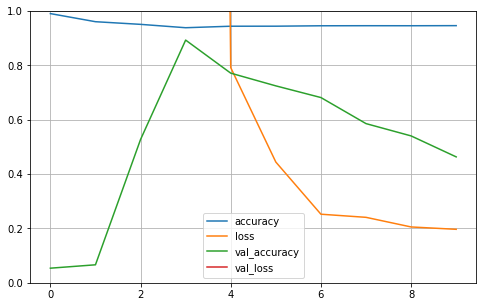

In [6]:
import pandas as pd
# Show the training process
pd.DataFrame(history.history).plot(figsize=(8, 5)) 
plt.grid(True)
plt.gca().set_ylim(0, 1)

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# Define the model
model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(train_features_array.shape[1], 1)),
    MaxPooling1D(2),
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_features_tensor[..., tf.newaxis], train_target_tensor, epochs=10, batch_size=128,
                    validation_data=(test_features_tensor[..., tf.newaxis], test_target_tensor))

# Evaluate the model
loss, accuracy = model.evaluate(test_features_tensor[..., tf.newaxis], test_target_tensor)
print(f"Test Accuracy: {accuracy:.2f}")


/opt/homebrew/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 70s 15ms/step - accuracy: 0.9422 - loss: 26.6507 - val_accuracy: 0.9462 - val_loss: 0.2310
Epoch 2/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 66s 14ms/step - accuracy: 0.9453 - loss: 0.2522 - val_accuracy: 0.9462 - val_loss: 0.2095
Epoch 3/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 65s 14ms/step - accuracy: 0.9458 - loss: 0.2106 - val_accuracy: 0.9462 - val_loss: 0.2095
Epoch 4/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 63s 13ms/step - accuracy: 0.9461 - loss: 0.2111 - val_accuracy: 0.9462 - val_loss: 0.2389
Epoch 5/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 64s 14ms/step - accuracy: 0.9455 - loss: 0.2139 - val_accuracy: 0.9462 - val_loss: 0.2095
Epoch 6/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 65s 14ms/step - accuracy: 0.9464 - loss: 0.2088 - val_accuracy: 0.9462 - val_loss: 0.2095
Epoch 7/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 65s 14ms/step - accuracy: 0.9451 - loss: 0.2128 - val_accuracy: 0.9462 - val_loss: 0.2095
Epoch 8/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 68s 14ms/step - accuracy: 0.9451 

Epoch 1/10


/opt/homebrew/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1172/1172 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9617 - loss: 112.8631 - val_accuracy: 0.0538 - val_loss: 21645.9180
Epoch 2/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9050 - loss: 950.1284 - val_accuracy: 0.0540 - val_loss: 15249.3809
Epoch 3/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9209 - loss: 595.2448 - val_accuracy: 0.0570 - val_loss: 11446.4834
Epoch 4/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9336 - loss: 395.5652 - val_accuracy: 0.1012 - val_loss: 9126.7832
Epoch 5/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9410 - loss: 284.5179 - val_accuracy: 0.1265 - val_loss: 8615.9023
Epoch 6/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9450 - loss: 237.6877 - val_accuracy: 0.1354 - val_loss: 8531.3770
Epoch 7/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9471 - loss: 217.3445 - val_accuracy: 0.1404 - val_loss: 8377.9414
Epoch 8/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accurac

2024-05-26 22:59:55.579837: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


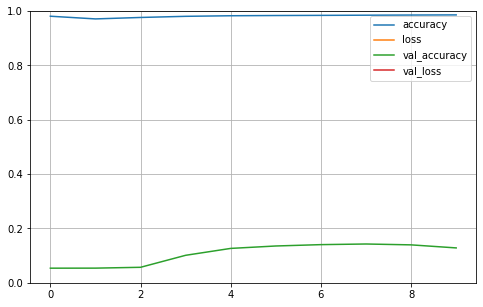

In [15]:
import pandas as pd
from tensorflow import keras

model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation='linear', input_shape=(train_features_array.shape[1],))
])

# Compile the model
model.compile(optimizer='adam',
              loss='hinge', 
              metrics=['accuracy'])

check_point = "Feedfowrad.keras"
# Train the model
history = model.fit(train_ds, epochs=10, batch_size = 128, validation_data=test_ds,
                   callbacks=[
                       tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10),
                       keras.callbacks.ModelCheckpoint(check_point, save_best_only=True)
                   ])
model = keras.models.load_model(check_point)

# Evaluate the model
loss, accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {accuracy:.2f}")

# Get model predictions for the test set
predictions = model.predict(test_ds)
predicted_labels = (predictions > 0).astype(int).flatten()

# Extract true labels from the test dataset
true_labels = np.concatenate([y.numpy() for x, y in test_ds], axis=0)

# Calculate metrics using TensorFlow functions
precision = tf.metrics.Precision()
recall = tf.metrics.Recall()

precision.update_state(true_labels, predicted_labels)
recall.update_state(true_labels, predicted_labels)

precision_value = precision.result().numpy()
recall_value = recall.result().numpy()

print(f"Precision: {precision_value:.2f}")
print(f"Recall: {recall_value:.2f}")

# Compute the confusion matrix
conf_matrix = tf.math.confusion_matrix(true_labels, predicted_labels)
print(f"Confusion Matrix:\n{conf_matrix.numpy()}")

# Show the training process
pd.DataFrame(history.history).plot(figsize=(8, 5)) 
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

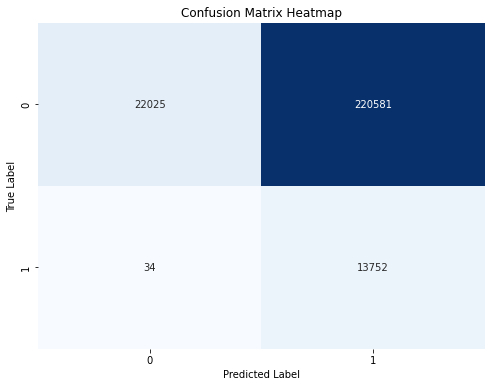

In [16]:
import seaborn as sns

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

/opt/homebrew/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 680s 145ms/step - accuracy: 0.9460 - loss: 0.1958 - val_accuracy: 0.9504 - val_loss: 0.1332
Epoch 2/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 725s 155ms/step - accuracy: 0.9624 - loss: 0.1209 - val_accuracy: 0.9733 - val_loss: 0.0655
Epoch 3/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 598s 128ms/step - accuracy: 0.9734 - loss: 0.0712 - val_accuracy: 0.9781 - val_loss: 0.0598
Epoch 4/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 624s 133ms/step - accuracy: 0.9784 - loss: 0.0573 - val_accuracy: 0.9815 - val_loss: 0.0506
Epoch 5/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 602s 128ms/step - accuracy: 0.9742 - loss: 0.0710 - val_accuracy: 0.9793 - val_loss: 0.0531
Epoch 6/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 598s 128ms/step - accuracy: 0.9788 - loss: 0.0581 - val_accuracy: 0.9819 - val_loss: 0.0492
Epoch 7/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 634s 135ms/step - accuracy: 0.9808 - loss: 0.0516 - val_accuracy: 0.9840 - val_loss: 0.0455
Epoch 8/10
4685/4685 ━━━━━━━━━━━━━━━━━━━━ 639s 136ms/step - ac

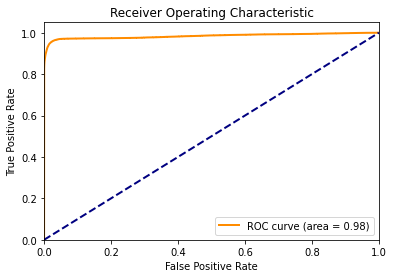

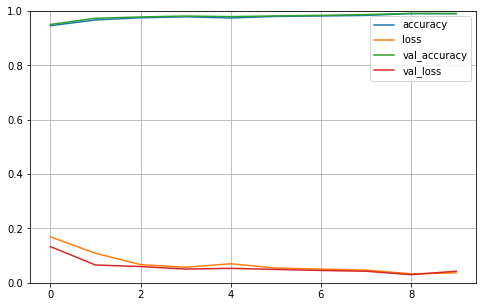

In [10]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

train_features_lstm = train_features_tensor[..., tf.newaxis]
test_features_lstm = test_features_tensor[..., tf.newaxis]

# Define the LSTM model architecture
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(train_features_lstm.shape[1], train_features_lstm.shape[2]), return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Use binary crossentropy for binary classification
              metrics=['accuracy'])

check_point = "LSTM_model.keras"
# Train the model
history = model.fit(train_features_lstm, train_target_tensor, epochs=10, batch_size=128,
                    validation_data=(test_features_lstm, test_target_tensor),
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10),
                        tf.keras.callbacks.ModelCheckpoint(check_point, save_best_only=True)
                    ])

model = tf.keras.models.load_model(check_point)

# Evaluate the model
loss, accuracy = model.evaluate(test_features_lstm, test_target_tensor)
print(f"Test Accuracy: {accuracy:.2f}")

# Get model predictions for the test set
predictions = model.predict(test_features_lstm).flatten()
predicted_labels = (predictions > 0.5).astype(int)

# Extract true labels from the test dataset
true_labels = test_target_tensor.numpy()

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
roc_auc = roc_auc_score(true_labels, predictions)

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

# Print confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(f"Confusion Matrix:\n{conf_matrix}")

# Calculate and plot ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, predictions)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Show the training process
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5)) 
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()


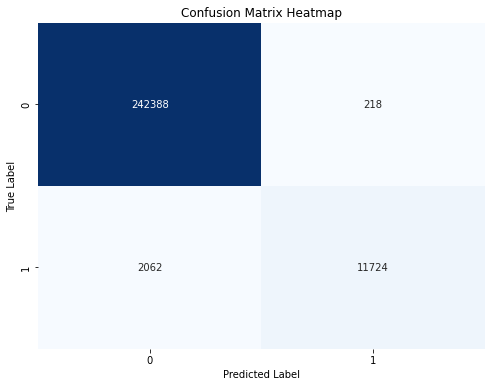

In [11]:
import seaborn as sns

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

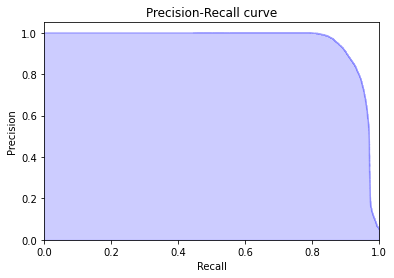

In [12]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(true_labels, predictions)

# Plot the PR curve
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.show()
